File name: main.ipynb

Author: ADAMsLEG

Date created: 03/11/2022

Date last modified: 23/11/2022

Python Version: 3.9


# Mental health during lockdowns through the eyes of Wikipedia
The Covid pandemic brought an undoubtedly change into our daily lives. Due to lockdowns, many people were forced to cut many of their social bounds, which we would expect had an impact on their mental health. As the basis of our analysis we use a time series dataset containing pageviews of selected Wikipedia articles in different languages related to mental health, hence we treat this research project as an observational study. Our first goal is to investigate if there was a change in pageviews of the selected Wikipedia articles during the covid lockdown period compared to the periods before and after. Secondly we will test if mobility had an impact on the readership of mental-health-related articles. We use mobility data from Apple and Google. Lastly, we compare the effects on mental health in different countries using the COVIDiSTRESS dataset. We aim to answer these questions by means of statistical analysis. In order to answer to do see, we need first to discover and understand the data we will handle. This is why we need to visualize the datasets.
## First approach with the datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import json
import gzip

In [2]:
DATA_PATH = "data/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"
TOPICS_LINKED_DATASET = DATA_PATH + "topics_linked.csv.xz"
AGGREGATED_JSON = DATA_PATH + "aggregated_timeseries.json.gz"

#### interventions.csv
This dataset contains a series of important dates associated with the pandemic. The dataset is very small - it has only 8 columns and 13 rows. The first column indicate the language. Other columns contain inmportant dates related to pandemic. If the event didn't occur, it is a NaN value. For English, the Wikipedia is too international, hence no country is assigned and there are many missing values. Mobility and Normalcy columns are based on the original paper. We will use this dataset in order to set the periods (before, during, after lockdown) for the given country.

In [3]:
df_interventions = pd.read_csv(INTERVENTIONS_DATASET)
df_interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15
9,ca,2020-01-31,2020-02-13,2020-03-12,2020-03-08,2020-03-14,2020-03-16,NaN


In [4]:
# Number of days per month in 2020
days = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# Converts date (string) to int. The function is designed only for the purpose of the interventions dataset. Value of January 1 2020 is 0. Each following day has value increased by 1.
def str_date_to_int(date):
    date = date.split('-')
    return sum(days[:int(date[1])-1]) + int(date[2]) - 1

# Converts int to a string containing the date using the same mapping as str_date_to_int. Works only for values 0 < x < 366
def int_to_str_date(date):
    date //= 1
    s = '2020-'
    i = 0
    date += 1
    while date > days[i]:
        date -= days[i]
        i += 1
    i += 1
    s += '0' + str(i) + '-'
    if date < 10:
        s += '0'
    s += str(date)
    return s[:-2]

In [5]:
# In order to get descriptive statistics for dates, we convert them to ints, calculate the given statistic, and convert the values back to date if appropriate.
# In this way we can get e.g. mean date of first case, quantile dates, etc..
for key in df_interventions.keys()[1:]:
    df_interventions[key] = df_interventions[key].apply(lambda x: str_date_to_int(x) if type(x) == str else x)

df_interventions_stats = df_interventions.describe()

for key in df_interventions_stats.keys():
    df_interventions_stats[key] = df_interventions_stats[key].apply(lambda x: int_to_str_date(x))
df_interventions_stats.iloc[0] = df_interventions_stats.iloc[0].apply(lambda x: str_date_to_int(x))
df_interventions_stats.iloc[2] = df_interventions_stats.iloc[2].apply(lambda x: str_date_to_int(x))

df_interventions_stats

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
count,12,12,12,11,7,13,12
mean,2020-02-06,2020-03-01,2020-03-10,2020-03-13,2020-03-18,2020-03-14,2020-06-02
std,17,13,7,7,4,7,24
min,2020-01-16,2020-02-13,2020-02-23,2020-02-25,2020-03-11,2020-02-25,2020-04-15
25%,2020-01-26,2020-02-18,2020-03-09,2020-03-10,2020-03-15,2020-03-11,2020-05-21
50%,2020-01-31,2020-03-01,2020-03-13,2020-03-12,2020-03-18,2020-03-16,2020-06-04
75%,2020-02-26,2020-03-11,2020-03-14,2020-03-18,2020-03-21,2020-03-16,2020-06-17
max,2020-03-06,2020-03-21,2020-03-18,2020-03-24,2020-03-24,2020-03-31,2020-07-10


#### topicslinked.csv.xz
This dataset contains the topic for the selected Wikipedia articles. The articles are identified by a name in index and a QID. All other ther columns are indicator variables that equal True if the corresponding page belongs to a topic and False otherwise - values (except qid) are of type bool. There are 4306126 rows and 65 columns.

In [6]:
df_topics = pd.read_csv(TOPICS_LINKED_DATASET, compression='xz')
df_topics.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q5465542


In [7]:
#Example: topics of articles containing the word anxiety
df_anxiety_keyword = df_topics.loc[df_topics['index'].str.contains('anxiety').fillna(False)]
df_anxiety_keyword.head(5) #Social_anxiety is in the STEM.Medicine & Health topic

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
29745,Social_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q3557657
100264,Intergroup_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q6046586
637466,Preoperational_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q7240583
805017,Library_anxiety,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q6542544
853325,Separation_anxiety_in_dogs,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q7451812


In [8]:
#We show the descriptive statistics. Since describe() shows only the most frequesnt value (which is False) and counts of True values are more interesting, we append it as the last row.
df_topics_stats = df_topics.describe()
N_articles_per_topics = {}
for key in df_topics_stats.keys():
    N_articles_per_topics[key] = (df_topics_stats[key]['count'] - df_topics_stats[key]['freq'])
df_topics_stats.append(N_articles_per_topics, ignore_index=True)

C:\Users\giann\AppData\Local\Temp\ipykernel_16312\873361220.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_topics_stats.append(N_articles_per_topics, ignore_index=True)


,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,4306125,4306126,4306126,4306126,4306126,4306126,4306126,4306126,4306126,4306126,...,4306126,4306126,4306126,4306126,4306126,4306126,4306126,4306126,4306126,4306126
1,4306125,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,4306126
2,Rosmalen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2001490
3,1,4295685,4135554,4128493,4209754,4221172,4258371,4190479,4203782,4081598,...,4170999,4279746,3947358,4272334,4233230,4267269,3971399,3687970,4279936,1
4,4306124,10441,170572,177633,96372,84954,47755,115647,102344,224528,...,135127,26380,358768,33792,72896,38857,334727,618156,26190,4306125


#### aggregated_timeseries.json.gz
This is a json dataset which contains number of views of articles per day per category per language. There are also data about covid articles but those are not relevant for our purpose. It also contains mobile data, when we use ".m" after the language in the first index. "Sum" index contains the data per day. The data is also expressed aas a percentage of total page views, when we use indedx "percent".

In [9]:
#read json as a dictionary
data = [] #dict
with gzip.open(AGGREGATED_JSON, 'r') as fin:
    data = json.loads(fin.read().decode('utf-8'))

### Example of use (source: bundled with data)
# data["it"]["topics"]["STEM.Computing"] — contains data related to the "STEM.Computing" topic.
# data["it"]["topics"]["STEM.Computing"] ["len"] —contains the number of distinct "STEM.Computing"-related pages considered in this language.
# data["it"]["topics"]["STEM.Computing"] ["sum"] — contains a time-series with the number of total pageviews going to "STEM.Computing"-related pages per day from the study period.
# data["it"]["topics"]["STEM.Computing"] [""percent"] — contains a time-series with the percentage of pageviews going to "STEM.Computing"-related pages per day from the study period.

#Example of data relevant for us which we convert to a dataframe
STEM_medicineandhealth_it = data["it"]["topics"]["STEM.Medicine & Health"] 
STEM_medicineandhealth_it = pd.DataFrame.from_dict(STEM_medicineandhealth_it)
STEM_medicineandhealth_nl = data["nl"]["topics"]["STEM.Medicine & Health"]
STEM_medicineandhealth_nl = pd.DataFrame.from_dict(STEM_medicineandhealth_nl)
STEM_medicineandhealth_sv = data["sv"]["topics"]["STEM.Medicine & Health"]
STEM_medicineandhealth_sv = pd.DataFrame.from_dict(STEM_medicineandhealth_sv)

STEM_medicineandhealth_it

,len,sum,percent
2018-01-01 00:00:00,13576,76109,0.009720
2018-01-02 00:00:00,13576,176646,0.013762
2018-01-03 00:00:00,13576,189202,0.014241
2018-01-04 00:00:00,13576,195989,0.014758
2018-01-05 00:00:00,13576,178431,0.014008
...,...,...,...
2020-07-27 00:00:00,13576,125237,0.014405
2020-07-28 00:00:00,13576,121975,0.014804
2020-07-29 00:00:00,13576,117198,0.014908
2020-07-30 00:00:00,13576,114620,0.013918


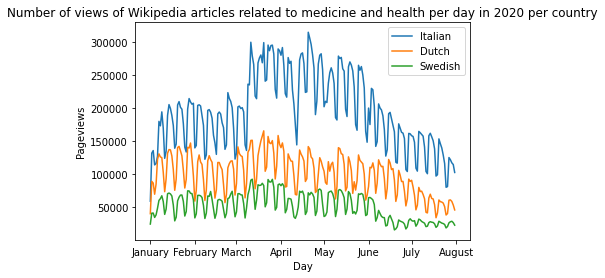

In [10]:
def cumulative_sum(arr):
    new_arr = [0]
    s = 0
    for i, x in enumerate(arr):
        s += x
        new_arr.append(x + new_arr[i])
    return new_arr

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']

# plot
fig, ax = plt.subplots()

## 730 corresponds to January 1 2020
ax.plot(STEM_medicineandhealth_it.index[730:], STEM_medicineandhealth_it['sum'][730:])
ax.plot(STEM_medicineandhealth_nl.index[730:], STEM_medicineandhealth_nl['sum'][730:])
ax.plot(STEM_medicineandhealth_sv.index[730:], STEM_medicineandhealth_sv['sum'][730:])

ax.set_xticks(cumulative_sum(days[:7]), months)
ax.set_title('Number of views of Wikipedia articles related to medicine and health per day in 2020 per country')
ax.set_ylabel('Pageviews')
ax.set_xlabel('Day')
ax.legend(['Italian', 'Dutch', 'Swedish'])

plt.show()

In the plot we can see lot of spikes, which are the difference between weekends and weekdays. Furthermore, during the period between March and June, when there was a lockdown in Italy, the increase in Wikipedia views in Italy seems to be larger than in the other 2 countries.

## COVIDiSTRESS
### Data cleaning
For the dataset COVIDiSTRESS, we take the already cleaned data from the survey [COVIDiSTRESS Global Survey dataset on psychological and behavioural consequences of the COVID-19 outbreak](https://www.nature.com/articles/s41597-020-00784-9#Sec7). We then process it for our needs and output an adapted version.
#### Set-up

In [11]:
PATH = 'data/COVIDISTRESS_unprocess_data/'

#getting the csv from COVIDistress 
df_april = pd.read_csv(PATH + 'COVIDiSTRESS_April_27_clean.csv', encoding= 'unicode_escape')
df_mai = pd.read_csv(PATH + 'COVIDiSTRESS_May_30_cleaned_final.csv', encoding= 'unicode_escape', low_memory=False)
df_june = pd.read_csv(PATH + 'COVIDiSTRESS June 17.csv', encoding= 'unicode_escape', low_memory=False)

##### Constant for cleaning

In [12]:
EUROPE_COUNTRY = ['Austria',
                  'Belgium',
                  'Bosnia and Herzegovina',
                  'Bulgaria',
                  'Croatia',
                  'Czech Republic',
                  'Denmark',
                  'Finland',
                  'France',
                  'Germany',
                  'Greece',
                  'Hungary',
                  'Ireland',
                  'Italy',
                  'Kosovo',
                  'Lithuania',
                  'Netherlands',
                  'Poland',
                  'Portugal',
                  'Serbia',
                  'Slovakia',
                  'Spain',
                  'Sweden',
                  'Switzerland',
                  'United Kingdom']

#columns that interest us for the analysis
COLUMNS_AVG = ['PSS10_avg', 'SLON3_avg']

#### 1st file: data from April 27
##### Overview
We start with a slight overview of the data, in order to understand what we are going to work with.

In [13]:
df_april.head(3)

,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,Country,...,Expl_media_6,Final_open,PSS10_avg,Lon_avg,neu,ext,ope,agr,con,SPS_avg
0,1,1058,2020-04-27 04:20:30,DA,33,Female,"College degree, bachelor, master",Some College or equivalent,Full time employed,Denmark,...,3.0,NaN,1.6,2.333333,2.000000,5.000000,4.666667,4.000000,3.666667,6.000000
1,2,1323,2020-04-27 04:17:16,NL,52,Male,"College degree, bachelor, master",Up to 12 years of school,Self-employed,Netherlands,...,4.0,Ik ben blij met de 'intelligente lockdown' zoa...,2.5,3.000000,4.666667,3.666667,5.000000,4.333333,4.666667,4.400000
2,3,801,2020-04-27 04:05:14,SK,52,Female,"College degree, bachelor, master",College degree,Full time employed,Slovakia,...,4.0,NaN,2.4,3.666667,3.000000,4.333333,4.333333,5.000000,4.666667,5.222222


In [14]:
print('This dataset contains ' + str(len(df_april)) + ' data points')

This dataset contains 115213 data points


##### Processing
We started by looking at the countries that interest us.

In [15]:
#groupe the df by country
country_groupe_april = df_april.groupby(['Country']).size()
country_groupe_april

Country
Afghanistan    110
Albania         79
Algeria         33
Andorra         14
Angola           9
              ... 
Venezuela        8
Vietnam        171
Zambia           4
Zimbabwe         4
other          218
Length: 173, dtype: int64

We can see here that we have >170 countries and that some of them only have a few data points. Hence we decided to keep only those that have >200 data points in order to have enough data per country.

In [16]:
#groupe countries that have >200 data point
country_groupe_april_filtered = country_groupe_april[country_groupe_april >= 200]

#Filters out the countries that doesn't have >200 data points
df_april_filtered = df_april[df_april['Country'].isin(country_groupe_april_filtered.index)]
country_april_over200 = df_april_filtered.groupby(['Country']).size()
print('There is ' + str(len(country_april_over200)) + ' countries that have more than 200 data points')

There is 41 countries that have more than 200 data points


We decided to orientate our evaluation to Europe countries, therefore we need to get ride of the other data from other countries

In [17]:
#change name of a columns for to coincide with the other datasets
df_april_filtered = df_april_filtered.rename(columns= {'Lon_avg' : 'SLON3_avg'})

#filters out the countries which aren't in the European List Country
df_april_filtered_EU = df_april_filtered[df_april_filtered['Country'].isin(EUROPE_COUNTRY)]
country_april_EU = df_april_filtered_EU.groupby(['Country']).size()
print('There is now only ' + str(len(country_april_EU)) + ' EU countries left')
print('And ' + str(len(df_april_filtered_EU)) + ' is the new size of the df')

There is now only 25 EU countries left
And 83525 is the new size of the df


##### Filtering NAs
Now that we have our countries of interest, we need to clean the data from any NAs in the columns of interest.

In [18]:
df_covidistress_april = df_april_filtered_EU.dropna(subset = COLUMNS_AVG)
print('The final dataset for the month of April is of size : ' + str(len(df_covidistress_april)))
print('There were ' + str(len(df_april_filtered_EU) - len(df_covidistress_april)) + ' data point which were discarded')

The final dataset for the month of April is of size : 77464
There were 6061 data point which were discarded


In [19]:
df_covidistress_april.head(3)

,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,Country,...,Expl_media_6,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg
0,1,1058,2020-04-27 04:20:30,DA,33,Female,"College degree, bachelor, master",Some College or equivalent,Full time employed,Denmark,...,3.0,NaN,1.6,2.333333,2.000000,5.000000,4.666667,4.000000,3.666667,6.000000
1,2,1323,2020-04-27 04:17:16,NL,52,Male,"College degree, bachelor, master",Up to 12 years of school,Self-employed,Netherlands,...,4.0,Ik ben blij met de 'intelligente lockdown' zoa...,2.5,3.000000,4.666667,3.666667,5.000000,4.333333,4.666667,4.400000
2,3,801,2020-04-27 04:05:14,SK,52,Female,"College degree, bachelor, master",College degree,Full time employed,Slovakia,...,4.0,NaN,2.4,3.666667,3.000000,4.333333,4.333333,5.000000,4.666667,5.222222


We now have our cleaned dataset for the data from Mai 30 2020

#### 2nd file: data from Mai 30 2020
##### Overview
We start with a slight overview of the data, in order to understand what we are going to work with.

In [20]:
df_mai.head(3)

,ID,answered_all,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,...,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg,Scale_UCLA_TRI_avg
0,1,No,180,2020-05-30 23:47:17,SAR,29,Female,"College degree, bachelor, master",Some College or equivalent,Not employed,...,NaN,2.9,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,No,3100,2020-05-29 23:30:15,UR,20,Male,"College degree, bachelor, master",None,Student,...,NaN,2.2,2.333333,2.0,5.0,5.333333,5.0,5.0,5.0,NaN
2,3,No,127,2020-05-30 22:40:15,SAR,47,Female,"Some College, short continuing education or eq...",Some College or equivalent,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
print('This dataset contains ' + str(len(df_mai)) + ' data points')

This dataset contains 125306 data points


##### Processing
We started by looking at the countries that interest us.

In [22]:
#group the df by country
country_groupe_mai = df_mai.groupby(['Country']).size()
country_groupe_mai

Country
Afghanistan    114
Albania         79
Algeria         38
Andorra         15
Angola          11
              ... 
Venezuela       11
Vietnam        173
Zambia           4
Zimbabwe         4
other          223
Length: 177, dtype: int64

We can see here that we also have >170 countries and that some of them also have only a few data points. Hence we decided to keep only those that have >200 data points in order to have enough data per country.

In [23]:
#groupe countries that have >200 data point
country_groupe_mai_filtered = country_groupe_mai[country_groupe_mai >= 200]

#Filters out the countries that doesn't have >200 data points
df_mai_filtered = df_mai[df_mai['Country'].isin(country_groupe_mai_filtered.index)]
country_mai_over200 = df_mai_filtered.groupby(['Country']).size()
print('There is ' + str(len(country_mai_over200)) + ' countries that have more than 200 data points')

There is 43 countries that have more than 200 data points


We then get ride of the other data from other countries.

In [24]:
#filters out the countries which aren't in the European List Country
df_mai_filtered_EU = df_mai_filtered[df_mai_filtered['Country'].isin(EUROPE_COUNTRY)]
country_mai_EU = df_mai_filtered_EU.groupby(['Country']).size()
print('There is now only ' + str(len(country_mai_EU)) + ' EU countries left')
print('And ' + str(len(df_mai_filtered_EU)) + ' is the new size of the df')

There is now only 25 EU countries left
And 88877 is the new size of the df


##### Filtering NAs
Now that we have our countries of interest, we need to clean the data from any NAs in the columns of interest.

In [25]:
df_covidistress_mai = df_mai_filtered_EU.dropna(subset = COLUMNS_AVG)
print('The final dataset for the month of Mai is of size : ' + str(len(df_covidistress_mai)))
print('There were ' + str(len(df_mai_filtered_EU) - len(df_covidistress_mai)) + ' data point which were discarded')

The final dataset for the month of Mai is of size : 82380
There were 6497 data point which were discarded


In [26]:
df_covidistress_mai.head(3)

,ID,answered_all,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,...,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg,Scale_UCLA_TRI_avg
3,4,No,1710,2020-05-29 22:47:17,BG,79,Male,"College degree, bachelor, master",College degree,Not employed,...,NaN,3.6,4.000000,4.000000,4.666667,4.000000,5.000000,5.000000,3.9,NaN
5,6,Yes,1221,2020-05-29 21:25:09,IT,68,Male,"College degree, bachelor, master",College degree,Retired,...,NaN,2.1,2.333333,3.333333,3.666667,4.333333,4.000000,3.666667,5.0,NaN
22,23,Yes,1004,2020-05-29 18:03:27,FR,28,Female,PhD/Doctorate,Up to 9 years of school,Full time employed,...,NaN,2.8,2.333333,4.666667,4.000000,5.333333,4.666667,3.333333,5.0,NaN


We now have our cleaned dataset for the data from Mai 30 2020

#### 3rd file: data from June 17 2020
##### Overview
We start with a slight overview of the data, in order to understand what we are going to work with.

In [27]:
df_june.head(3)

,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,Country,...,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg,Scale_UCLA_TRI_avg
0,1,777,2020-06-17 01:01:39,NL,48,Female,"College degree, bachelor, master",NaN,Full time employed,Netherlands,...,Reguliere ziekenhuiszorg is verminderd: mijn c...,2.4,2.666667,4.000000,3.666667,4.666667,4.333333,5.000000,5.1,NaN
1,2,952,2020-06-16 23:19:18,PL,36,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,Poland,...,NaN,1.7,1.000000,2.333333,3.666667,3.000000,3.666667,4.666667,5.3,NaN
2,3,2396,2020-06-16 22:47:36,EN,45,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,Finland,...,NaN,1.7,2.000000,2.666667,4.333333,5.000000,5.000000,5.000000,5.2,NaN


In [28]:
print('This dataset contains ' + str(len(df_june)) + ' data points')

This dataset contains 126405 data points


##### Processing
We started by looking at the countries that interest us.

In [29]:
#group the df by country
country_groupe_june = df_june.groupby(['Country']).size()
country_groupe_june

Country
Afghanistan    115
Albania         80
Algeria         38
Andorra         15
Angola          11
              ... 
Venezuela       11
Vietnam        173
Zambia           4
Zimbabwe         4
other          224
Length: 177, dtype: int64

We can see here that we also have >170 countries and that some of them also have only a few data points. Hence we decided to keep only those that have >200 data points in order to have enough data per country.

In [30]:
#groupe countries that have >200 data point
country_groupe_june_filtered = country_groupe_june[country_groupe_mai >= 200]

#Filters out the countries that doesn't have >200 data points
df_june_filtered = df_june[df_june['Country'].isin(country_groupe_june_filtered.index)]
country_june_over200 = df_june_filtered.groupby(['Country']).size()
print('There is ' + str(len(country_june_over200)) + ' countries that have more than 200 data points')

There is 43 countries that have more than 200 data points


We then get ride of the other data from other countries.

In [31]:
#filters out the countries which aren't in the European List Country
df_june_filtered_EU = df_june_filtered[df_june_filtered['Country'].isin(EUROPE_COUNTRY)]
country_june_EU = df_june_filtered_EU.groupby(['Country']).size()
print('There is now only ' + str(len(country_june_EU)) + ' EU countries left')
print('And ' + str(len(df_june_filtered_EU)) + ' is the new size of the df')

There is now only 25 EU countries left
And 89179 is the new size of the df


##### Filtering NAs
Now that we have our countries of interest, we need to clean the data from any NAs in the columns of interest.

In [32]:
df_covidistress_june = df_june_filtered_EU.dropna(subset = COLUMNS_AVG)
print('The final dataset for the month of June is of size : ' + str(len(df_covidistress_june)))
print('There were ' + str(len(df_june_filtered_EU) - len(df_covidistress_june)) + ' data point which were discarded')

The final dataset for the month of June is of size : 82646
There were 6533 data point which were discarded


In [33]:
df_covidistress_june.head(3)

,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,Country,...,Final_open,PSS10_avg,SLON3_avg,neu,ext,ope,agr,con,SPS_avg,Scale_UCLA_TRI_avg
0,1,777,2020-06-17 01:01:39,NL,48,Female,"College degree, bachelor, master",NaN,Full time employed,Netherlands,...,Reguliere ziekenhuiszorg is verminderd: mijn c...,2.4,2.666667,4.000000,3.666667,4.666667,4.333333,5.000000,5.1,NaN
1,2,952,2020-06-16 23:19:18,PL,36,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,Poland,...,NaN,1.7,1.000000,2.333333,3.666667,3.000000,3.666667,4.666667,5.3,NaN
2,3,2396,2020-06-16 22:47:36,EN,45,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,Finland,...,NaN,1.7,2.000000,2.666667,4.333333,5.000000,5.000000,5.000000,5.2,NaN


Let's get the median because we are looking at likert scale values and can't look at the means

In [34]:
#get median of Stress, and loneliness in each months
PSS10_col = [col for col in df_april_filtered_EU if col.startswith('Scale_PSS10_UCLA')]
SLON_col_april = [col for col in df_april_filtered_EU if col.startswith('Scale_Lon')]
SLON_col = [col for col in df_mai_filtered_EU if col.startswith('Scale_SLON')]
#april
df_april_filtered_EU['median_stress'] = np.floor(df_april_filtered_EU[PSS10_col].median(axis=1))
df_april_filtered_EU['median_loneliness'] = np.floor(df_april_filtered_EU[SLON_col_april].median(axis=1))
#mai
df_mai_filtered_EU['median_stress'] = np.floor(df_mai_filtered_EU[PSS10_col].median(axis=1))
df_mai_filtered_EU['median_loneliness'] = np.floor(df_mai_filtered_EU[SLON_col].median(axis=1))
#june
df_june_filtered_EU['median_stress'] = np.floor(df_june_filtered_EU[PSS10_col].median(axis=1))
df_june_filtered_EU['median_loneliness'] = np.floor(df_june_filtered_EU[SLON_col].median(axis=1))

C:\Users\giann\AppData\Local\Temp\ipykernel_16312\2133416405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_april_filtered_EU['median_stress'] = np.floor(df_april_filtered_EU[PSS10_col].median(axis=1))
C:\Users\giann\AppData\Local\Temp\ipykernel_16312\2133416405.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_april_filtered_EU['median_loneliness'] = np.floor(df_april_filtered_EU[SLON_col_april].median(axis=1))
C:\Users\giann\AppData\Local\Temp\ipykernel_16312\2133416405.py:9: SettingWithCopyW

We noticed ealier some nan values, lets filters it in median columns

In [35]:
#count and print nan values in Slon and PSS10
months = ['April', 'Mai', 'June']
#april
print('NA in April stress: ', df_april_filtered_EU['median_stress'].isna().sum())
print('In april loneliness: ', df_april_filtered_EU['median_loneliness'].isna().sum())
print('Tot in April: ', len(df_april_filtered_EU['median_stress']))

#mai
print('NA in Mai stress: ', df_mai_filtered_EU['median_stress'].isna().sum())
print('In Mai loneliness: ', df_mai_filtered_EU['median_loneliness'].isna().sum())
print('Tot in Mai: ', len(df_mai_filtered_EU['median_stress']))

#june
print('NA in June stress: ', df_june_filtered_EU['median_stress'].isna().sum())
print('In June loneliness: ', df_june_filtered_EU['median_loneliness'].isna().sum())
print('Tot in June: ', len(df_june_filtered_EU['median_stress']))

NA in April stress:  5878
In april loneliness:  6041
Tot in April:  83525
NA in Mai stress:  6302
In Mai loneliness:  6476
Tot in Mai:  88877
NA in June stress:  6336
In June loneliness:  6511
Tot in June:  89179


In [36]:
#drop nan values in median_stress and median_loneliness for each month
medians_col = ['median_stress', 'median_loneliness']
df_april_filtered = df_april_filtered_EU.dropna(subset=medians_col)
df_mai_filtered = df_mai_filtered_EU.dropna(subset=medians_col)
df_june_filtered = df_june_filtered_EU.dropna(subset=medians_col)

#check if there are still nan values
print('NA in April stress: ', df_april_filtered['median_stress'].isna().sum())
print('In april loneliness: ', df_april_filtered['median_loneliness'].isna().sum())
print('Tot in April: ', len(df_april_filtered['median_stress']))

#mai
print('NA in Mai stress: ', df_mai_filtered['median_stress'].isna().sum())
print('In Mai loneliness: ', df_mai_filtered['median_loneliness'].isna().sum())
print('Tot in Mai: ', len(df_mai_filtered['median_stress']))

#june
print('NA in June stress: ', df_june_filtered['median_stress'].isna().sum())
print('In June loneliness: ', df_june_filtered['median_loneliness'].isna().sum())
print('Tot in June: ', len(df_june_filtered['median_stress']))



NA in April stress:  0
In april loneliness:  0
Tot in April:  77464
NA in Mai stress:  0
In Mai loneliness:  0
Tot in Mai:  82380
NA in June stress:  0
In June loneliness:  0
Tot in June:  82646


In [37]:
#new feature period
df_april_filtered['period'] = 'April'
df_mai_filtered['period'] = 'Mai'
df_june_filtered['period'] = 'June'

#merge all the dataframes
df_covidistress = pd.concat([df_april_filtered, df_mai_filtered, df_june_filtered])

C:\Users\giann\AppData\Local\Temp\ipykernel_16312\3344792511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_april_filtered['period'] = 'April'
C:\Users\giann\AppData\Local\Temp\ipykernel_16312\3344792511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mai_filtered['period'] = 'Mai'
C:\Users\giann\AppData\Local\Temp\ipykernel_16312\3344792511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [38]:
#keep only data from 4 countries
COUNTRIES_INTEREST = ['Italy', 'Sweden', 'Netherlands', 'Poland']
df_covidistress = df_covidistress[df_covidistress['Country'].isin(COUNTRIES_INTEREST)]

In [39]:
#extract df into csv
df_covidistress.to_csv(DATA_PATH + '\\' 'df_covidistress_clean.csv', index = False)


We now have our cleaned dataset for the data from June 17 2020

### COVIDiSTRESS visualization
We will now visualize the data which interest us, which are the average perceived stress (PSS10_avg) and the average perceived loneliness (SLON3_avg) accross the month of April to June in Italie, Poland, the Netherlands and Sweden. Theses values are scaled between 1 to 5 on a likert scale, where 1 = never and 5 = very often.

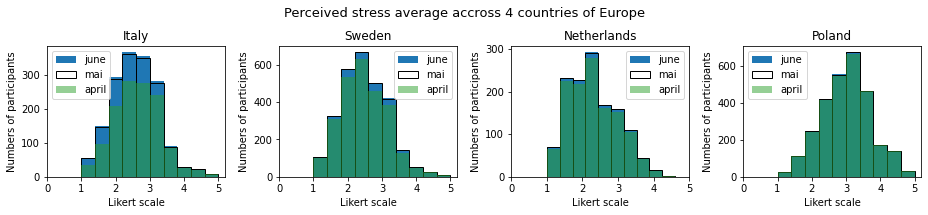

In [40]:
#list of months to choose data set and countries of interests
MONTHS = ['june', 'mai', 'april']
COUNTRIES_INTEREST = ['Italy', 'Sweden', 'Netherlands', 'Poland']

#plot histogramme of the avg PSS by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()

for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df by countries of interest
    df_hist_june = df_covidistress_june.loc[df_covidistress_june['Country'] == country]
    df_hist_mai = df_covidistress_mai.loc[df_covidistress_mai['Country'] == country]
    df_hist_april = df_covidistress_april.loc[df_covidistress_april['Country'] == country]
    #plot
    axe.hist(df_hist_june['PSS10_avg'][:])
    axe.hist(df_hist_mai['PSS10_avg'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['PSS10_avg'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived stress average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)

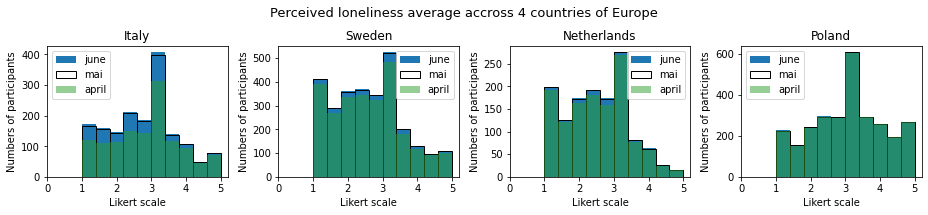

In [41]:
#plot histogramme of the avg PSS by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()
for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df for countries of interest
    df_hist_june = df_covidistress_june.loc[df_covidistress_june['Country'] == country]
    df_hist_mai = df_covidistress_mai.loc[df_covidistress_mai['Country'] == country]
    df_hist_april = df_covidistress_april.loc[df_covidistress_april['Country'] == country]
    #plot
    axe.hist(df_hist_june['SLON3_avg'][:])
    axe.hist(df_hist_mai['SLON3_avg'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['SLON3_avg'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived loneliness average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)

However, likert scale values being ordinal scale, we can't really analyze the means but rather the medians, so let's have a look at it.

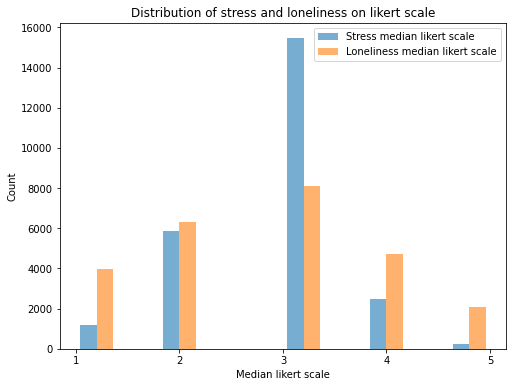

In [42]:
#plot compare distribution of stress and loneliness

plt.figure(figsize=(8,6))
plt.hist([df_covidistress['median_stress'],df_covidistress['median_loneliness']], alpha=0.6, label=['Stress median likert scale', 'Loneliness median likert scale'])
plt.xticks([1,2,3,4,5])
plt.xlabel('Median likert scale')
plt.ylabel('Count')
plt.title('Distribution of stress and loneliness on likert scale')
plt.legend(loc='upper right')
plt.show()

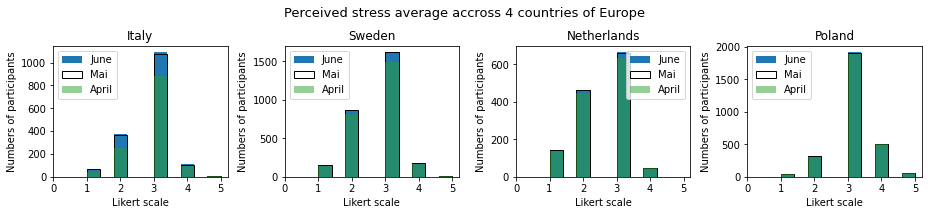

In [43]:
#list of months to choose data set and countries of interests
MONTHS = ['June', 'Mai', 'April']
COUNTRIES_INTEREST = ['Italy', 'Sweden', 'Netherlands', 'Poland']

#plot histogramme of the stress median by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()

for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df by countries of interest and month
    df_hist_june = df_june_filtered.loc[df_june_filtered['Country'] == country]
    df_hist_mai = df_mai_filtered.loc[df_mai_filtered['Country'] == country]
    df_hist_april = df_april_filtered.loc[df_april_filtered['Country'] == country]
    #plot
    axe.hist(df_hist_june['median_stress'][:])
    axe.hist(df_hist_mai['median_stress'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['median_stress'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived stress average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()



With a closer look at the median perception of stress in each country, the normalize distribution seems to shift a bit on the left except for Poland 

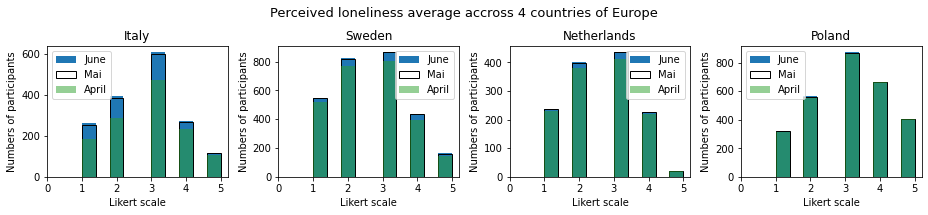

In [44]:
#plot histogramme of the loneliness median by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()

for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df by countries of interest and month
    df_hist_june = df_june_filtered.loc[df_june_filtered['Country'] == country]
    df_hist_mai = df_mai_filtered.loc[df_mai_filtered['Country'] == country]
    df_hist_april = df_april_filtered.loc[df_april_filtered['Country'] == country]
    #plot
    axe.hist(df_hist_june['median_loneliness'][:])
    axe.hist(df_hist_mai['median_loneliness'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['median_loneliness'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived loneliness average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()



The same goes for loneliness median perception

## Dataset: Wikipedia:Pageview statistics

As we said in the Read.me, in order to analyze mental health awareness during lockdowns of Covid19, we decided to consider 5 mental disorders: anxiety, depression, loneliness, insomnia and physiological stress. For each of these diseases, we will use the number of Wikipedia page views about these diseases in the period 2019-01-01 - 2022-09-01. All data was downloaded from the website Wikipedia:Pageview statistics (https://pageviews.wmcloud.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&range=latest-20&pages=).

Let's see what the data looks like (only first few dates)

In [45]:
with open('{}.json'.format('./data/anxiety_en'), 'r') as file:
    data = json.load(file)[0]

print('First few dates')    
dict(list(data.items())[0: 10]) 

First few dates


{'page': 'Anxiety disorder',
 'sum': 1991316,
 'daily_average': 1454,
 '2019-01-01': 1486,
 '2019-01-02': 1842,
 '2019-01-03': 1715,
 '2019-01-04': 1724,
 '2019-01-05': 1872,
 '2019-01-06': 1771,
 '2019-01-07': 1968}

We have the page name, the total number of page views for the selected period, the average number of views per day and the number of page views for each day of the period. Let's make one table for all data in which there will be 6 columns: 

[PageName, Date, PageViews, Month, Year ,Month/Year]

Fortunately, there are no missing values in this dataset, but there are some outliers. To cope with these outliers, we will use an interquartile range approach. Define as 

Q1 = PageViews.quantile(0.25), Q3 = PageViews.quantile(0.75), IQR = Q3 - Q1.
We will delete all values that are not in range:

[Q1 - 1.5 * IQR; Q3 + 1.5 * IQR]

In [46]:
diseases_names = ['anxiety_en', 'depression_en', 'insomnia_en', 'loneliness_en', 'stress_en']

def get_data():
    # create DataFrame
    df = pd.DataFrame({'PageName' :[], 'Date':[], 'PageViews':[]}) 
    for disease in diseases_names:
        # read files
        with open('./data/{}.json'.format(disease), 'r') as file: 
            data = json.load(file)[0]
            # convert string to date type
            date = pd.to_datetime(list(data.keys())[3:])
            # add data to DataFrame
            df = pd.concat([df, pd.DataFrame({'PageName' :[disease]*(len(data)-3), 'Date':date.date, 
                                              'Month':list(map(lambda x: x[5:7], list(data.keys())[3:])),
                                              'Year':list(map(lambda x: x[:4], list(data.keys())[3:])), 
                                              'Day':list(map(lambda x: x[8:], list(data.keys())[3:])),
                                              'Month/Year': list(date.strftime('%m/%Y')), 
                                              'PageViews':list(data.values())[3:]})])
    
    
    # interquartile range approach for deleting outliers
    Q1 = df['PageViews'].quantile(0.25)
    Q3 = df['PageViews'].quantile(0.75)
    IQR = Q3 - Q1    

    df = df[(df['PageViews'] >= Q1 - 1.5 * IQR) & (df['PageViews'] <= Q3 + 1.5 *IQR)] 
    
    return df

In [47]:
df = get_data()
df.head()

,PageName,Date,PageViews,Month,Year,Day,Month/Year
0,anxiety_en,2019-01-01,1486.0,01,2019,01,01/2019
1,anxiety_en,2019-01-02,1842.0,01,2019,02,01/2019
2,anxiety_en,2019-01-03,1715.0,01,2019,03,01/2019
3,anxiety_en,2019-01-04,1724.0,01,2019,04,01/2019
4,anxiety_en,2019-01-05,1872.0,01,2019,05,01/2019


In [48]:
from datetime import datetime

# A function for plotting boxplots of page views by month for a given page and period [start_date, end_date]

def plot_monthly_stats(df, page_name, start_date, end_date, show_outliers=False):
    sns.set(rc={'figure.figsize':(12,8)})
    plt.title('Monthly boxplots of page views for {} from {} to {}'.format(page_name, start_date, end_date))
    
    #consider only data in period [start_date, end_date]
    data = df[(df['Date'] >= datetime.strptime(start_date, '%Y-%m-%d').date())  &  
              (df['Date'] <= datetime.strptime(end_date, '%Y-%m-%d').date())]

    # plot boxplot    
    ax = sns.boxplot(x='Month/Year', y="PageViews", data=data,
                        showmeans=True, showfliers=show_outliers)
    # plot average of pageviews by month 
    ax = sns.pointplot(x='Month/Year', y="PageViews", data=data,
                       errorbar=None, color='black')
    # Put the date on the x axis vertically 
    ax.tick_params(axis='x', labelrotation=90)

Let's plot the distribution of page views on the topic "Depression" during 2020.

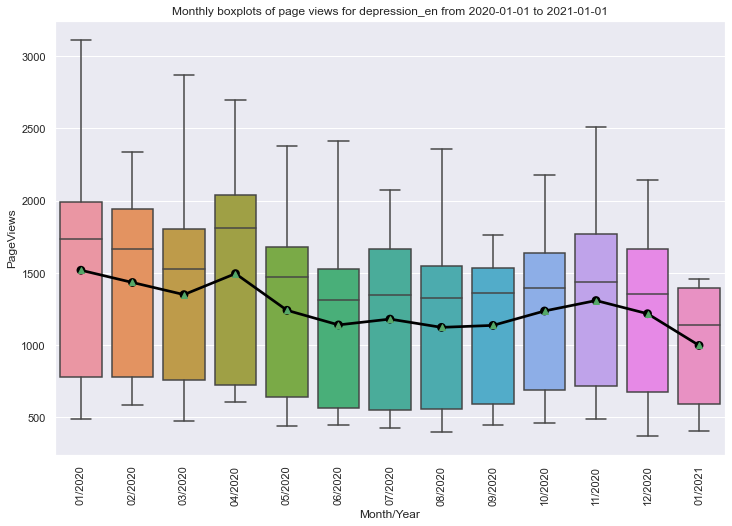

In [49]:
plot_monthly_stats(df, page_name='depression_en', start_date='2020-01-01', end_date='2021-01-01', show_outliers=True)

In [50]:
#A function for plotting the average number of pageviews by month for all disorders for a given period
# [start_date, end_date]

def plot_compare_disorders(df, start_date, end_date, errorbar='sd'):
    data = df[(df['Date'] >= datetime.strptime(start_date, '%Y-%m-%d').date())  &  
              (df['Date'] <= datetime.strptime(end_date, '%Y-%m-%d').date())]
    
    plt.title('Monthly average number of pageviews for each disorders from {} to {} by topics'.format(start_date, end_date))
    ax = sns.lineplot(x="Month/Year", y="PageViews", data=data, errorbar=errorbar, hue="PageName")
    ax.tick_params(axis='x', labelrotation=90)

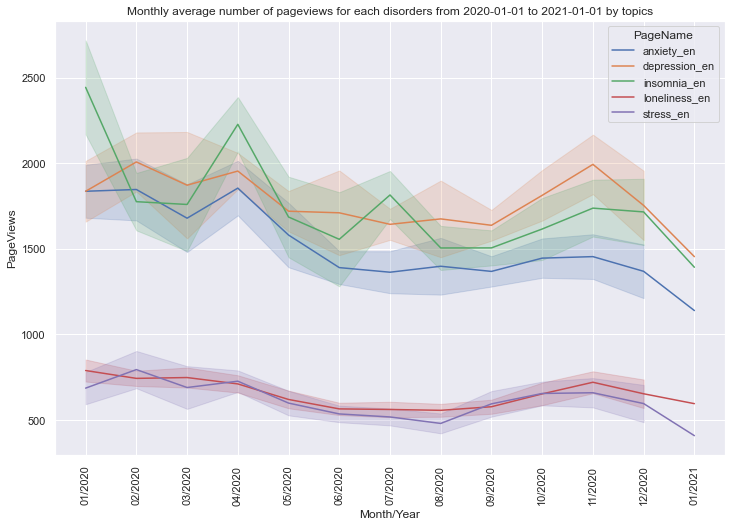

In [51]:
plot_compare_disorders(df, start_date='2020-01-01', end_date='2021-01-01')

In [52]:
# A function for plotting the average monthly number of page views about a given disorder by year

def plot_compare_disprder_by_years(df, page_name='depression_en', errorbar='sd'):
    plt.title('Monthly average number of pageviews about {} by years'.format(page_name))
    ax = sns.lineplot(x="Month", y="PageViews", data=df[df['PageName'] == page_name], errorbar=errorbar, hue="Year")

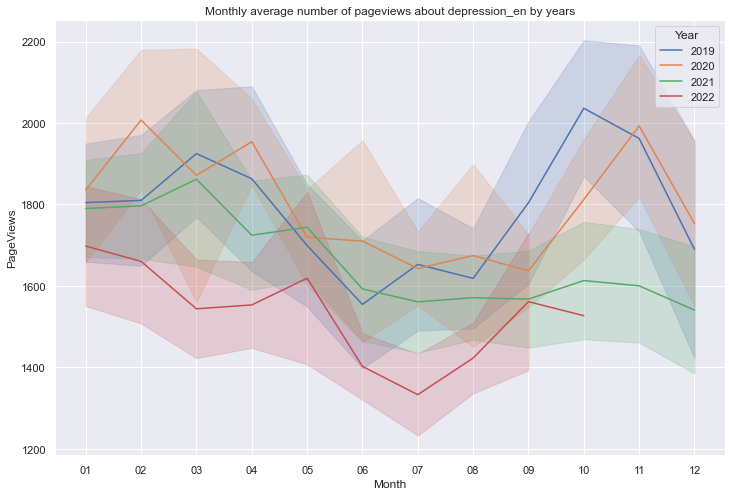

In [53]:
plot_compare_disprder_by_years(df, page_name='depression_en')

Let's do a t-test in which we compare the average number of views of the Wikipedia page about depression in 2020 and in 2021. Let's check whether their average differs statistically significantly and if so, we will try to understand in which direction.

In [54]:
def cohen_d(sample_A, sample_B):
    '''
     Compute cohen's d value for independent values
     :param sample_A and sample_B: pd.DataFrame
     :return: d
     '''
    diff_mean = np.abs(np.mean(sample_A) - np.mean(sample_B))
    nb_A = len(sample_A)
    nb_B = len(sample_B)
    A_sd = np.std(sample_A)
    B_sd = np.std(sample_B)
    
    pooled_sd = np.sqrt(((nb_A-1) * A_sd**2 + (nb_B-1) * B_sd**2)/(nb_A + nb_B -2))
    
    d = diff_mean/pooled_sd
    
    print('Cohen s d effect size value is d = ' + str(d) 
      + ' with the sample size n = ' + str(len(sample_A)))
    
    return d

# Function for conducting T-test.

def test_pageviews_means(page_name):
    # Take pageviews statistics  
    depression_2020 = df[(df['Year'] == '2020') & (df['PageName'] == page_name)]['PageViews'].to_list()
    depression_2021 = df[(df['Year'] == '2021') & (df['PageName'] == page_name)]['PageViews'].to_list()

    # Find mean for each year
    mean_2020 = np.mean(depression_2020)
    mean_2021 = np.mean(depression_2021)
    
    # T-tes. Assume that variance doesn't change
    tvalue2, pvalue2 = stats.ttest_ind(depression_2020, depression_2021, equal_var= True)
    
    print('Pvalue of the sample t-test for the pageviews statistic about {} in 2020 and 2021:\n {}\n'.format(page_name, pvalue2))
    cohen_d(depression_2020, depression_2021)
    print('\nPageviews mean for 2020 and 2021 and their difference: \n  {}, {}, {}'.format(mean_2020, mean_2021, mean_2020-mean_2021))

In [55]:
test_pageviews_means('depression_en')

Pvalue of the sample t-test for the pageviews statistic about depression_en in 2020 and 2021:
 1.8919218606161319e-19

Cohen s d effect size value is d = 0.6894364266588466 with the sample size n = 362

Pageviews mean for 2020 and 2021 and their difference: 
  1799.7845303867402, 1663.0438356164384, 136.74069477030184


It is clear from the test results that p_value < 0.05 and  the Cohen's effect is large, so we can reject the hypothesis that they have the same average value. Also we can notice  that on average in 2020 the number of views of the Wikipedia page about depression is greater than in 2021. This gives us some confidence that we can actually see changes in awareness of mental health problems during covid.

### Apple Mobility Trends Dataset
- AppleMobilityTrends contains data representing the daily change in mobility compared to the start date of 13/01/2020
- For each country/city contained in the dataset distinguishes between driving/transit/walking transpotation types.(some dont have transit data)
- The dataset has 152 countries and 196 cities 
- The data is clean and has no NaN values

In [56]:
DATA_PATH = "data/"
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends-2020-04-20.csv.gz"
appleMobilityData = pd.read_csv(APPLE_MOBILITY_DATASET, compression='gzip')
appleMobilityData.head()

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,country/region,Albania,driving,100,95.30,101.43,97.20,103.55,112.67,104.83,...,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51
1,country/region,Albania,walking,100,100.68,98.93,98.46,100.85,100.13,82.13,...,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72
2,country/region,Argentina,driving,100,97.07,102.45,111.21,118.45,124.01,95.44,...,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67
3,country/region,Argentina,walking,100,95.11,101.37,112.67,116.72,114.14,84.54,...,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44
4,country/region,Australia,driving,100,102.98,104.21,108.63,109.08,89.00,99.35,...,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93


In [57]:
appleMobilityData.isnull().values.any() #no NaN values

False

In [58]:
mobilityItaly  = appleMobilityData.loc[appleMobilityData['region'] == "Italy"]
mobilityItaly

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
65,country/region,Italy,driving,100,102.63,105.41,106.18,114.69,127.45,110.65,...,22.00,12.66,15.13,21.84,23.68,24.21,24.65,22.42,19.40,22.62
66,country/region,Italy,transit,100,100.82,100.40,99.52,107.35,113.33,108.25,...,9.27,8.71,10.25,11.23,11.32,11.20,11.22,10.60,11.38,12.05
67,country/region,Italy,walking,100,102.10,104.86,107.32,122.71,142.38,109.49,...,20.58,11.43,12.05,15.41,17.06,17.77,18.86,19.21,15.37,14.46


In [59]:
#Aggregate daily data into weekly

#How to aggregate daily data for weekly: https://towardsdatascience.com/daily-to-weekly-pandas-c0557b12f052
def new_case_count(state_new_cases):
    first_Monday_found = False
    week_case_count = 0
    week_case_counts = []
    for index, value in state_new_cases.items():
        index_date = pd.to_datetime(index, format='%Y/%m/%d', 
                                    exact = False)
        index_day_of_week = index_date.day_name()
        if not first_Monday_found and index_day_of_week != 'Monday':
            continue
        first_Monday_found = True
        week_case_count += value
        if index_day_of_week == 'Sunday':
            week_case_counts.append(week_case_count/7) #Here added divide by 7 since we want average over week isntead of sum
            week_case_count = 0
    return week_case_counts

mobilityItalyDrivingDates = mobilityItaly.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
mobilityItalyDrivingDates.index = ['driving', 'transit', 'walking']
# converting list to DataFrame object
weeklyMobilityDataItaly = pd.DataFrame(new_case_count(mobilityItalyDrivingDates))
weeklyMobilityDataItaly.head(10)

,driving,transit,walking
2020-01-13,109.572857,104.238571,112.694286
2020-01-20,110.798571,105.520000,114.955714
2020-01-27,109.122857,103.200000,117.272857
2020-02-03,111.072857,106.491429,121.074286
2020-02-10,122.731429,118.468571,141.558571
2020-02-17,121.698571,121.125714,142.827143
2020-02-24,93.077143,78.302857,89.464286
2020-03-02,81.771429,58.552857,67.457143
2020-03-09,28.652857,18.112857,23.512857
2020-03-16,18.277143,10.160000,15.248571


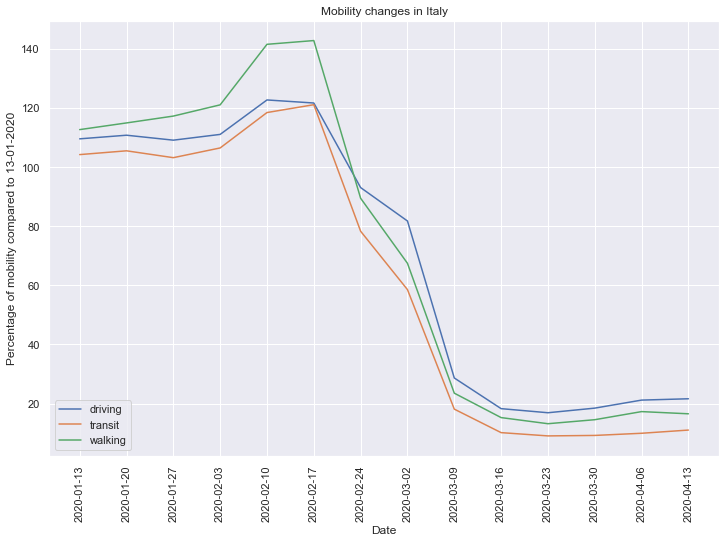

In [60]:
plt.plot(weeklyMobilityDataItaly)
plt.title("Mobility changes in Italy")
plt.xticks(rotation=90)
plt.ylabel("Percentage of mobility compared to 13-01-2020")
plt.xlabel("Date")
legend = list(weeklyMobilityDataItaly.columns)
plt.legend(legend, loc='lower left')
plt.show()


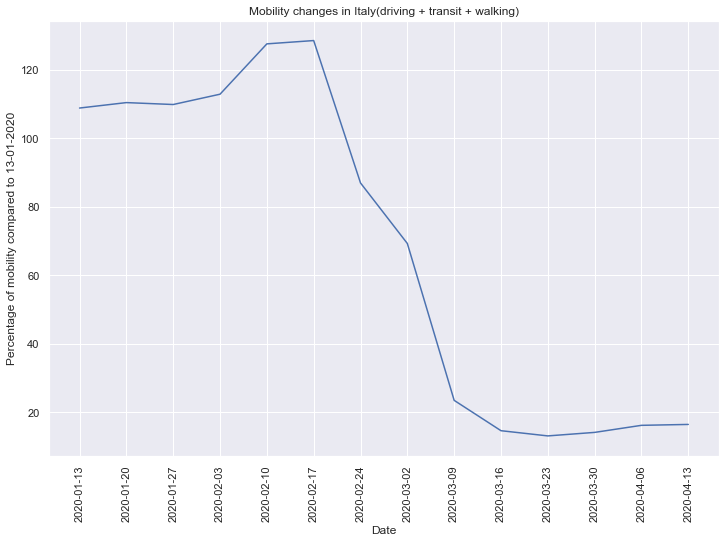

In [61]:
AggWeeklyMobilityDataItaly = weeklyMobilityDataItaly.mean(axis=1) #average over driving+transit+walking

plt.plot(AggWeeklyMobilityDataItaly)
plt.title("Mobility changes in Italy(driving + transit + walking)")
plt.xticks(rotation=90)
plt.ylabel("Percentage of mobility compared to 13-01-2020")
plt.xlabel("Date")
plt.show()

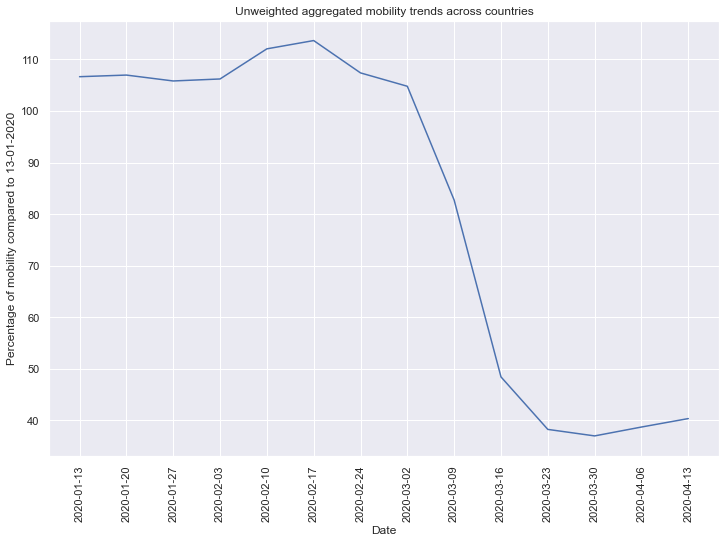

In [62]:
#World mobility over all countries/each country given same weight
mobilityCountries  = appleMobilityData.loc[appleMobilityData['geo_type'] == "country/region"]
mobilityCountriesMixed = mobilityCountries.drop(columns = ['geo_type', 'region', 'transportation_type']);
weeklyMobilityCountriesMixed = pd.DataFrame(new_case_count(mobilityCountriesMixed))
weeklyMobilityCountriesMixed = weeklyMobilityCountriesMixed.mean(axis=1)

plt.plot(weeklyMobilityCountriesMixed)
plt.title("Unweighted aggregated mobility trends across countries")
plt.xticks(rotation=90)
plt.ylabel("Percentage of mobility compared to 13-01-2020")
plt.xlabel("Date")
plt.show()

### Apple mobility trends extended version(jan 2020 until april 2022)
- Very similar to the provided apple mobility dataset except is has the extra columns "alternative_name", "country"
- AppleMobilityTrends contains data representing the daily change in mobility compared to the start date of 13/01/2020
- For each country/city contained in the dataset distinguishes between driving/transit/walking transpotation types.(some dont have transit data)
- The dataset has some NaN values however not many and they could be cleaned by taken the average of previous and next day

In [63]:
#Extended apple mobility trends
DATA_PATH = "data/"
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends.csv"
appleMobilityData = pd.read_csv(APPLE_MOBILITY_DATASET, low_memory=False)
appleMobilityData.head()

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2022-04-03,2022-04-04,2022-04-05,2022-04-06,2022-04-07,2022-04-08,2022-04-09,2022-04-10,2022-04-11,2022-04-12
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,...,149.58,156.76,156.76,151.02,157.86,185.12,196.62,173.11,173.21,171.09
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,...,161.71,215.31,221.62,211.34,189.25,244.22,231.90,154.93,223.97,223.45
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,...,93.32,97.74,102.63,106.26,111.81,145.45,158.56,99.20,100.82,114.56
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,...,88.58,126.43,133.06,135.64,142.40,178.26,172.83,98.96,126.57,139.29
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,...,123.95,116.32,132.29,134.97,145.09,146.34,125.79,136.60,139.01,146.75


In [64]:
appleMobilityData = appleMobilityData.drop(columns = ['alternative_name', 'country', 'sub-region'], axis=1)

In [65]:
mobilityItaly  = appleMobilityData.loc[appleMobilityData['region'] == "Italy"]
appleMobilityData.isnull().values.any() #no NaN values
mobilityItaly

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2022-04-03,2022-04-04,2022-04-05,2022-04-06,2022-04-07,2022-04-08,2022-04-09,2022-04-10,2022-04-11,2022-04-12
65,country/region,Italy,driving,100.0,102.63,105.41,106.18,114.69,127.45,110.65,...,160.40,145.69,149.97,153.63,161.28,180.13,199.24,189.55,164.01,170.59
66,country/region,Italy,transit,100.0,100.82,100.40,99.52,107.35,113.33,108.25,...,358.35,339.03,332.75,346.80,368.27,405.73,430.29,398.35,368.65,371.13
67,country/region,Italy,walking,100.0,102.10,104.86,107.32,122.71,142.38,109.49,...,210.96,182.43,192.05,190.58,213.43,253.88,294.05,257.32,224.51,232.29


In [66]:
mobilityItalyFiltered = mobilityItaly.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
mobilityItalyFiltered.index = ['driving', 'transit', 'walking']
mobilityItalyFiltered

,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,...,2022-04-03,2022-04-04,2022-04-05,2022-04-06,2022-04-07,2022-04-08,2022-04-09,2022-04-10,2022-04-11,2022-04-12
driving,100.0,102.63,105.41,106.18,114.69,127.45,110.65,102.59,103.94,106.67,...,160.40,145.69,149.97,153.63,161.28,180.13,199.24,189.55,164.01,170.59
transit,100.0,100.82,100.40,99.52,107.35,113.33,108.25,102.14,99.04,100.05,...,358.35,339.03,332.75,346.80,368.27,405.73,430.29,398.35,368.65,371.13
walking,100.0,102.10,104.86,107.32,122.71,142.38,109.49,99.19,102.26,105.19,...,210.96,182.43,192.05,190.58,213.43,253.88,294.05,257.32,224.51,232.29


In [67]:
mobilityItalyFilteredT =  mobilityItalyFiltered.T
mobilityItalyFilteredT.index = pd.to_datetime(mobilityItalyFiltered.T.index)

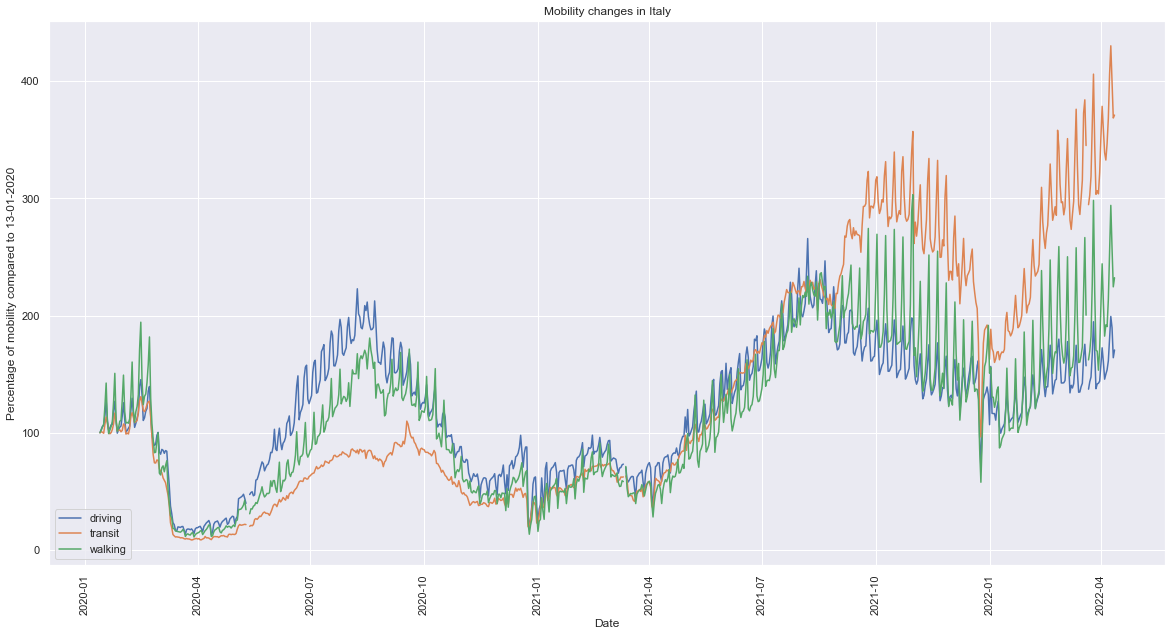

In [68]:
plt.figure(figsize=(20,10))
plt.plot(mobilityItalyFilteredT)
plt.title("Mobility changes in Italy")
plt.xticks(rotation=90)
plt.ylabel("Percentage of mobility compared to 13-01-2020")
plt.xlabel("Date")
#legend = list(mobilityItaly.columns)
plt.legend(legend, loc='lower left')
plt.show()

In [69]:
# converting list to DataFrame object
mobilityItalyFiltered.index = ['driving', 'transit', 'walking']
weeklyMobilityDataItaly = pd.DataFrame(new_case_count(mobilityItalyFiltered))
weeklyMobilityDataItaly.head(10)

,driving,transit,walking
2020-01-13,109.572857,104.238571,112.694286
2020-01-20,110.798571,105.520000,114.955714
2020-01-27,109.122857,103.200000,117.272857
2020-02-03,111.072857,106.491429,121.074286
2020-02-10,122.731429,118.468571,141.558571
2020-02-17,121.698571,121.125714,142.827143
2020-02-24,93.077143,78.302857,89.464286
2020-03-02,81.771429,58.552857,67.457143
2020-03-09,28.652857,18.112857,23.512857
2020-03-16,18.277143,10.160000,15.248571


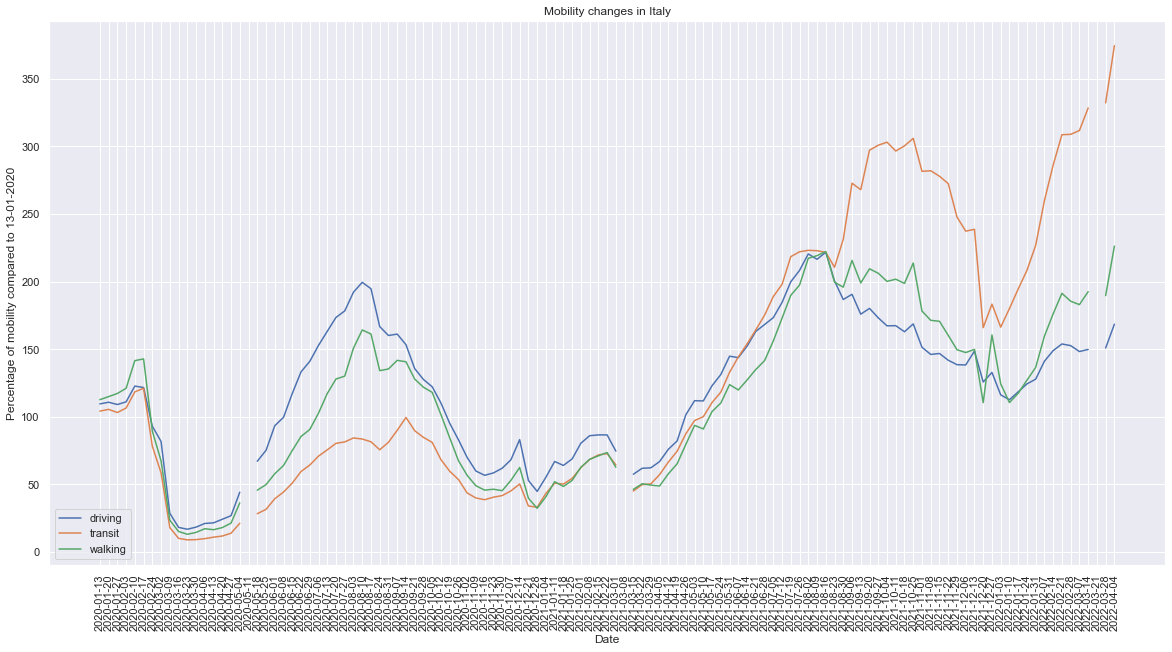

In [70]:
plt.figure(figsize=(20,10))
plt.plot(weeklyMobilityDataItaly)
plt.title("Mobility changes in Italy")
plt.xticks(rotation=90)
plt.ylabel("Percentage of mobility compared to 13-01-2020")
plt.xlabel("Date")
legend = list(weeklyMobilityDataItaly.columns)
plt.legend(legend, loc='lower left')
plt.show()

### Global Mobility Dataset
- This dataset contains data change in percentage from baseline(before covid) for 6 categories of mobility('Grocery and Pharmacy', 'Parks', 'Transit Sations', 'Workplace', 'Residential')
- This dataset contains few NaN values in the columns containing information on percentagechanges, but not many so they can be easily filled using average of previous and next day if necessary
- This dataset contains data for 135 different country/regions
- We are not interrested in the sub_regions/metro area for our project

In [71]:
DATA_PATH = "data/"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"
df_global = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip', low_memory=False)
df_global.head(2)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0


In [72]:
df_global['country_region'].nunique()

135

In [73]:
#Get country level data and fill NaN values
italy_data = df_global[df_global['country_region_code'] == 'IT']
italy_data_filtered = italy_data[italy_data['sub_region_1'].isna()] #keep only rows with country level data (for italy only using sub_region_1 is enough)
italy_data_filtered = italy_data_filtered.dropna(axis=1, how='all') #keep only rows without NaN values(should drop all "sub_region"s)
italy_data_filtered = italy_data_filtered.interpolate() #replace NaN values with average of bfill and ffill (No NaN values in this filtered dataframe but not necessarily the case)
italy_data_filtered = italy_data_filtered.set_index(pd.DatetimeIndex(italy_data_filtered['date']))
del italy_data_filtered['date']
italy_data_fitered = italy_data_filtered.drop_duplicates()
italy_data_filtered.head(3)

,country_region_code,country_region,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,
2020-02-15,IT,Italy,3.0,-1.0,35.0,9.0,0.0,-1.0
2020-02-16,IT,Italy,3.0,2.0,26.0,11.0,1.0,-2.0
2020-02-17,IT,Italy,0.0,1.0,7.0,3.0,1.0,0.0


C:\Users\giann\AppData\Local\Temp\ipykernel_16312\1110424860.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  italy_filtered_daily = italy_data_filtered.resample("D").mean() #average per day, and remove all non numerical columns


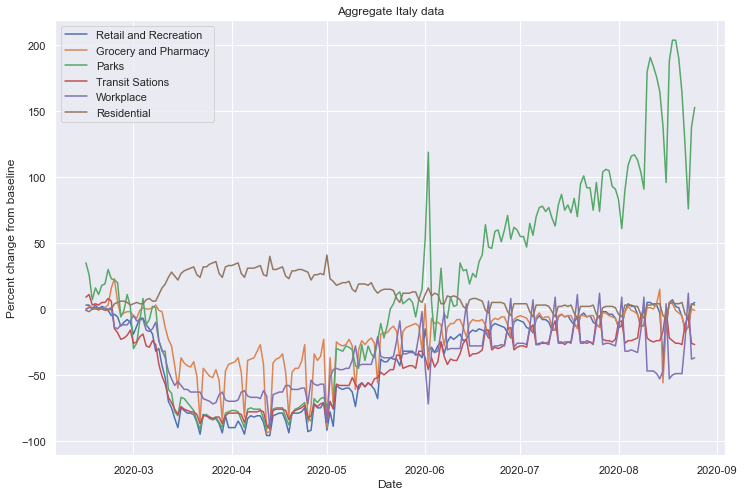

In [74]:
italy_filtered_daily = italy_data_filtered.resample("D").mean() #average per day, and remove all non numerical columns 
plt.plot(italy_filtered_daily)
legend = list(['Retail and Recreation', 'Grocery and Pharmacy', 'Parks', 'Transit Sations', 'Workplace', 'Residential'])
#legend = list(italy_filtered_daily.columns)
plt.title("Aggregate Italy data")
plt.legend(legend, loc = "upper left")
plt.ylabel("Percent change from baseline")
plt.xlabel("Date")
plt.show()

C:\Users\giann\AppData\Local\Temp\ipykernel_16312\194160535.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  italy_filtered_weekly = italy_data_filtered.resample("W").mean() #W of week, M for month


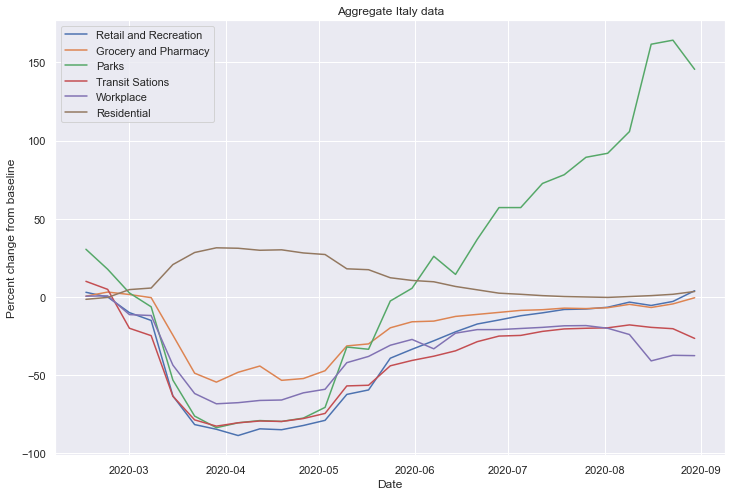

In [75]:
#average over weeks to get smoother graph
italy_filtered_weekly = italy_data_filtered.resample("W").mean() #W of week, M for month
plt.plot(italy_filtered_weekly)
legend = list(['Retail and Recreation', 'Grocery and Pharmacy', 'Parks', 'Transit Sations', 'Workplace', 'Residential'])
#legend = list(italy_filtered_daily.columns)
plt.title("Aggregate Italy data")
plt.legend(legend, loc = "upper left")
plt.ylabel("Percent change from baseline")
plt.xlabel("Date")
plt.show()

### Google Trends
We can use google trends API to get the weekly  ‘interest’ in certain keywords over the previous 5 year period. This data is clean and allows us to see the variations in interest on google to certain words. We can use this data to backup the wikipedia pageview statistics.

In [76]:
#must pip install pytrends
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ["fatica", "ansia", "angoscia", "solitudine", "isonnia"] 
#ansia, angoscia and ansietà all widely used words to say stress
#italians also commonly say "stress". Fatica also means tired in italian
#kw_list = ["depression", "stress", "anxiety", "loneliness", "insomnia"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')

data = pytrends.interest_over_time()
data

ModuleNotFoundError: No module named 'pytrends'

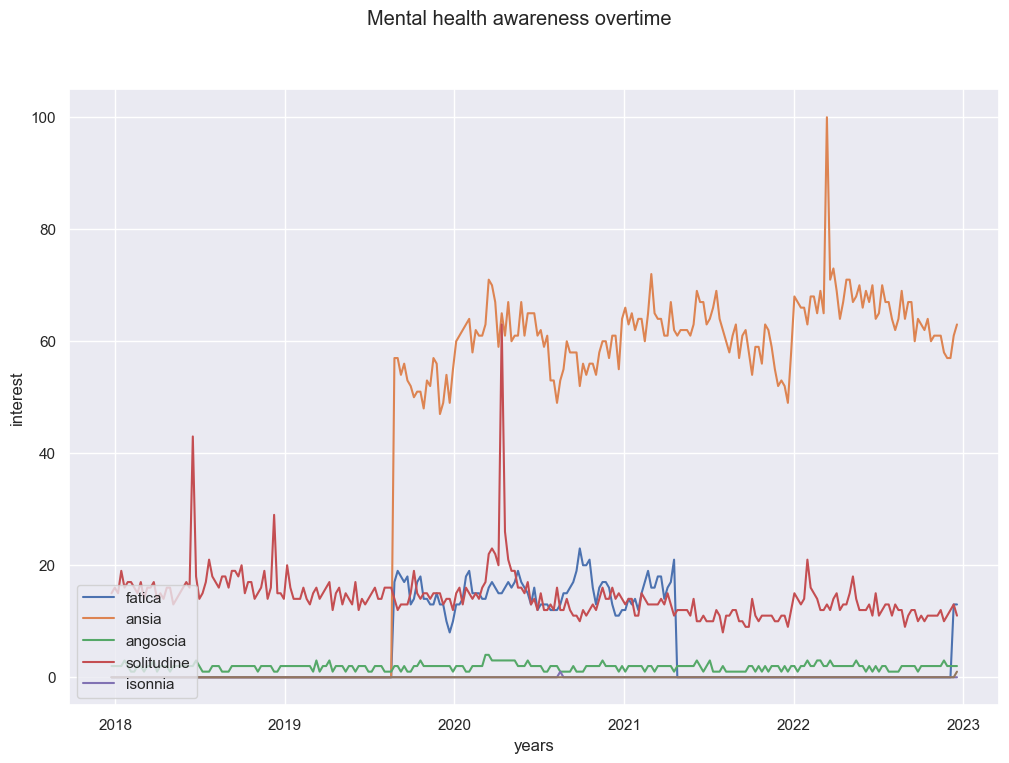

In [ ]:
 #plot data
import matplotlib.pyplot as plt

plt.suptitle("Mental health awareness overtime")
plt.xlabel("years")
plt.ylabel("interest")

plt.plot(data)
plt.legend(kw_list, loc='lower left')
plt.show()
#plt.savefig("data.png")
#focus = ["anxiety", "loneliness"]
#plt.plot(data[focus])